# survival_curves.ipynb

## Notes for Colab Version

This notebook was imported from a [Colab version](https://colab.research.google.com/drive/1_c7tr1AixnwoncvC7tOHOmBJQmDzZv6H) and heavily modified.

This notebook generates survival curves using data from the the MySQL project database. Figures generated are intended for the HTML report I am working on.

Once the plots are generated, manually download them, one by one into the GitHub repository (ornv-bioassay-db).

At some point, this script will pause to request a username and a password for the MySQL database. Username is **aubreymoore** and password is **Canada_????**.

## Notes for This Version

Instead of using a MySQL database, this version imports data from **../db_tables/beetles.csv**.



In [1]:
import sys; sys.version

'3.9.5 (default, Nov 23 2021, 15:27:38) \n[GCC 9.3.0]'

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import lifelines # for survival analysis
import os
import scipy.stats
from datetime import datetime
import math

In [3]:
def get_data():
    df = pd.read_csv('../db_tables/beetles.csv')
  
    # select the columns we are interested in
    df = df[['sn','date_dosed','dose_mg','treatment','dose_mg','date_dead','died_during_bioassay']]
 
    # convert date_dosed to datetime and remove records for beetles which were not dosed 
    # needed to use errors because dates include '000-00-00' which is invalid
    df['date_dosed'] = pd.to_datetime(df['date_dosed'], errors='coerce')
    df = df[df.date_dosed.notnull()]

    # convert date_dead to datetime and remove records where date_dead is null
    df['date_dead'] = pd.to_datetime(df['date_dead'], errors='coerce')
    df = df[df.date_dead.notnull()]

    # convert 0, 1 column to boolean
    df['died_during_bioassay'] = df.died_during_bioassay.astype(bool)
     
    # add days_post_treatment column
    df['days_post_treatment'] = (df['date_dead'] - df['date_dosed']).dt.days
   
    return df

# df= get_data()
# df

In [4]:
def perform_survival_analysis(df, treatment, figure_filename):
    treated = df.treatment == treatment
    untreated = df.treatment == 'CONTROL'

    stats = lifelines.statistics.logrank_test(
      durations_A = df[treated]['days_post_treatment'],
      durations_B = df[untreated]['days_post_treatment'],
      event_observed_A = df[treated]['died_during_bioassay'],
      event_observed_B = df[untreated]['died_during_bioassay'])

    if stats.p_value < 0.05:
        stats_result = f'Difference between curves is significant (logrank test; p = {stats.p_value:.3f})'
    else:
        stats_result = f'Difference between curves is not significant\n(logrank test; p = {stats.p_value:.3f})'

    plt.clf()
    ax = plt.subplot()
    kmf = lifelines.KaplanMeierFitter()

    kmf.fit(durations=df[treated]['days_post_treatment'],
          event_observed=df[treated]['died_during_bioassay'],
          label='treated')
    
    LT50_treated = kmf.median_survival_time_
    if LT50_treated == math.inf:
        LT50_treated = 'na'
    else:
        LT50_treated = int(LT50_treated)

    kmf.plot(figsize=(8,8), ax=ax, ci_show=False, color='red', linewidth=5)

    kmf.fit(durations=df[untreated]['days_post_treatment'],
          event_observed=df[untreated]['died_during_bioassay'],
          label='untreated')
    
    LT50_untreated = kmf.median_survival_time_
    if LT50_untreated == math.inf:
        LT50_untreated = 'na'
    else:
        LT50_untreated = int(LT50_untreated)
    
    kmf.plot(figsize=(8,8), ax=ax, ci_show=False, color='black', linewidth=3)

    title = f'''{figure_filename.replace('.png', '')}
      Survival curves estimated with Kaplan-Meier Fitter
      {stats_result}
      proportion of untreated beetles surviving: {1 - sum(untreated & df.died_during_bioassay)/sum(untreated):.2f}
      proportion of treated beetles surviving: {1 - sum(treated & df.died_during_bioassay)/sum(treated):.2f}
      untreated LT50: {LT50_untreated} days
      treated LT50: {LT50_treated} days'''

    plt.title(title)
    plt.xlabel('days after treatment')
    plt.ylabel('proportion surviving')
    plt.savefig(f'../survival_curves/{figure_filename}', bbox_inches='tight')

# perform_survival_analysis(df1, 'DUG42', 'test.png')

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.10 0.75      0.41
<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.21 0.65      0.63
<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.37 0.54      0.88
<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.98 0.32      1.64
<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared

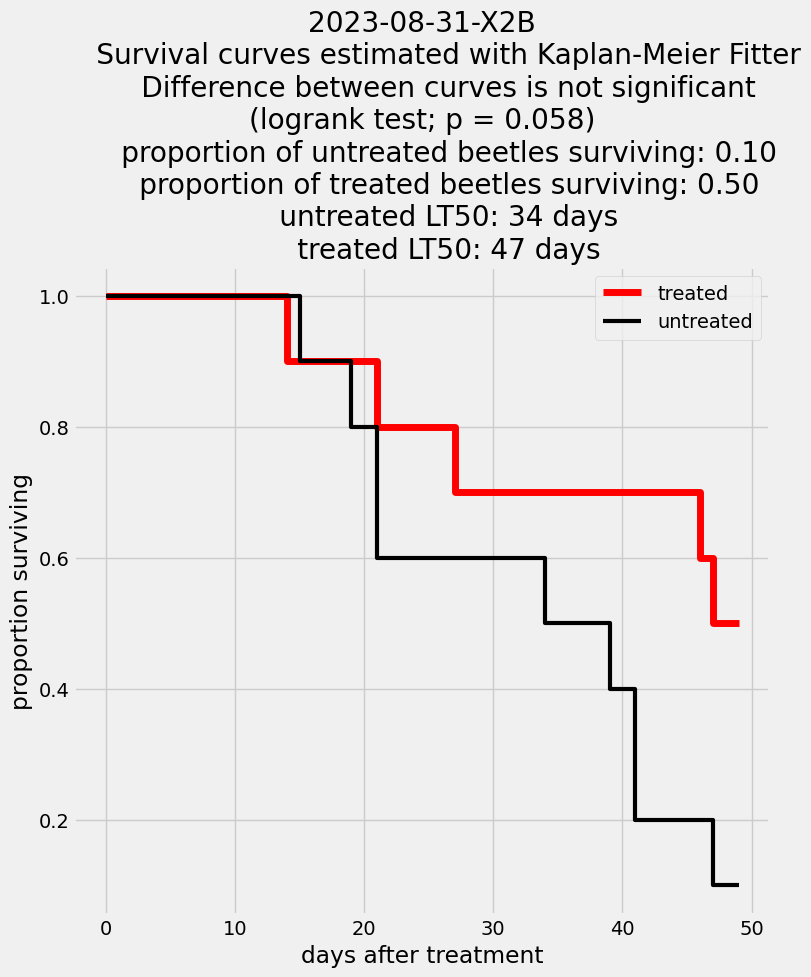

In [5]:
# MAIN

df = get_data()
date_dosed_list = sorted(df.date_dosed.unique())
for date_dosed in date_dosed_list:
    df1 = df[df.date_dosed == date_dosed]
    treatment_list = sorted(list(df1.treatment.unique()))
    for treatment in treatment_list:
        if treatment != 'CONTROL':
            figure_filename = f'{str(date_dosed)[:10]}-{treatment}.png'
            perform_survival_analysis(df1, treatment, figure_filename)

In [6]:
print('FINISHED')

FINISHED
